In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVR

In [2]:
traindata = pd.read_table('train_FD001.txt',sep=' ',header=None)
traindata.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [3]:
traindata.shape

(20631, 28)

In [4]:
rul_given = pd.read_table('RUL_FD001.txt',sep=' ',header=None)
rul_given.head()

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [5]:
rul_given[0].describe()

count    100.00000
mean      75.52000
std       41.76497
min        7.00000
25%       32.75000
50%       86.00000
75%      112.25000
max      145.00000
Name: 0, dtype: float64

In [6]:
def preproc(df,key):
    
    # data preprocessing
    sensordata = df.drop([0,1,2,3,4,26,27],axis=1)
    cols = range(1,22)
    sensordata.columns = cols
    X = sensordata.drop([1,5,6,10,16,18,19],axis=1)
    
    # RUL creation
    g = df.groupby([0])
    d = (g.last()).sort_index().reset_index().drop_duplicates()
    d.drop(d.columns.difference([1]),axis=1,inplace=True)
    RUL_set = 125
    RUL = []
    
    if(key=='test'):
        rul_given = pd.read_table('RUL_FD001.txt',sep=' ',header=None)
        d[1] = d[1]+rul_given[0]
    
    for row in range(df.shape[0]):
        i = df[0][row] - 1
        if df[1][row] <= (d[1][i] - RUL_set):
            RUL.append(RUL_set)
        else:
            RUL.append(d[1][i] - df[1][row])
    RUL = np.asarray(RUL)  
    
    return X, RUL

In [7]:
X_train, Y_train = preproc(traindata,'train')
X_train.head()

,2,3,4,7,8,9,11,12,13,14,15,17,20,21
0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


In [8]:
Y_train

array([125, 125, 125, ...,   2,   1,   0], dtype=int64)

In [9]:
print("X_train shape: ",X_train.shape)
print("Y_train shape: ",Y_train.shape)

X_train shape:  (20631, 14)
Y_train shape:  (20631,)


In [10]:
testdata = pd.read_table('test_FD001.txt',sep=' ',header=None)
testdata.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN


In [11]:
testdata.shape

(13096, 28)

In [12]:
X_test, Y_test = preproc(testdata,'test')
X_test.head()

,2,3,4,7,8,9,11,12,13,14,15,17,20,21
0,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735
1,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916
2,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166
3,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737
4,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130


In [13]:
Y_test

array([125, 125, 125, ...,  22,  21,  20], dtype=int64)

In [14]:
print("X_test shape: ",X_test.shape)
print("Y_test shape: ",Y_test.shape)

X_test shape:  (13096, 14)
Y_test shape:  (13096,)


Text(0.5, 1.0, 'Training turbine 1')

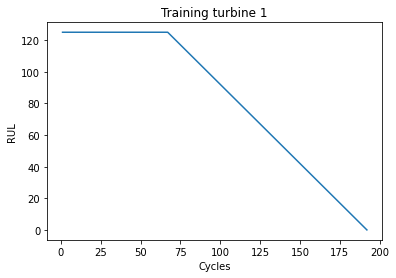

In [15]:
plt.plot(range(1,193),Y_train[0:192])
plt.xlabel('Cycles')
plt.ylabel('RUL')
plt.title('Training turbine 1')

Text(0.5, 1.0, 'Testing turbine 1')

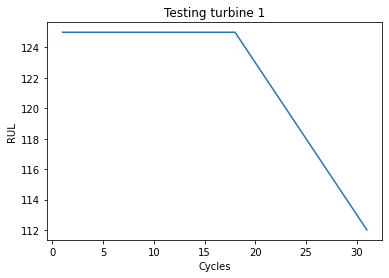

In [16]:
plt.plot(range(1,32),Y_test[0:31])
plt.xlabel('Cycles')
plt.ylabel('RUL')
plt.title('Testing turbine 1')

In [17]:
normaliser = MinMaxScaler(feature_range = (-1,1))
normaliser.fit_transform(X_train)
normaliser.fit(X_test)

MinMaxScaler(feature_range=(-1, 1))

In [18]:
svm = SVR(C=1000, gamma=0.001, kernel='rbf')

In [19]:
svm.fit(X_train,Y_train)

SVR(C=1000, gamma=0.001)

In [20]:
result = svm.predict(X_test)

In [21]:
print(np.sqrt(mean_squared_error(result,Y_test)))

17.5358143839021


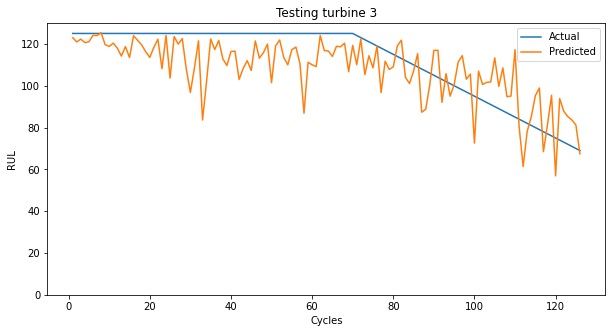

In [22]:
fig=plt.figure(figsize=[10,5])
plt.plot(range(1,127),Y_test[80:206])
plt.plot(range(1,127),result[80:206])
plt.ylim([0,130])
plt.xlabel('Cycles')
plt.ylabel('RUL')
plt.title('Testing turbine 3')
plt.legend(['Actual','Predicted'])
#fig.savefig('SVR Test Turbine 3.jpg', bbox_inches='tight', dpi=800)

Text(0.5, 1.0, 'Testing turbine 3 - RUL Deviation')

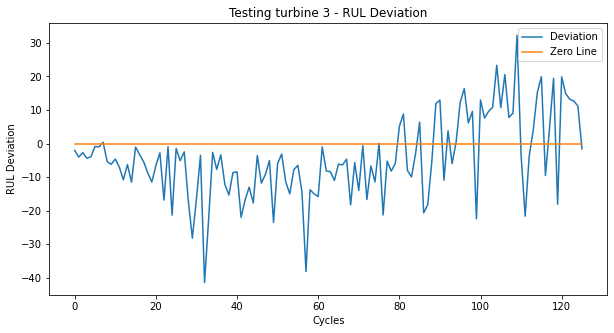

In [23]:
fig=plt.figure(figsize=[10,5])
plt.plot(result[80:206]-Y_test[80:206])
plt.plot(np.zeros((126)))
plt.xlabel('Cycles')
plt.ylabel('RUL Deviation')
plt.legend(['Deviation','Zero Line'])
plt.title('Testing turbine 3 - RUL Deviation')